# My Project

So for my project I wanted to go back to my valorant data set from Unit 3. This time I wanted to figure out what factors affect Average Combat Score.

# Imports & Data Sorting

In [3]:
import numpy as np
import pandas as pd
import arviz as az
import preliz as pz
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import graphviz as gv

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
#Here just reading the data from my GitHub
data = pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_3/players_stats.csv")

In [5]:
#Now I'm running a .query that only selects data that is from 1 singular tournament as it 1 helps limit data points in the interest of run time 
#and 2 helps reduce bias as different regionas have different play styles so taking data from an international tournament helps average this out
#the other 2 parts are just sorting out some quirks in my data
data = data.query('Tournament == "Valorant Champions 2023" & ~Agents.str.contains(",") & `Match Type` == "All Match Types"')

In [6]:
#I think using Agents as a hierarchy is something I really want to do, but there are too many agents to make it really useful, so
#I can group the agents based on their class as is done in game. Below is a dictionary where I have done that
agent_types = {'Duelist': ['jett', 'raze', 'reyna', 'yoru', 'neon', 'phoenix'], 
               'Controller': ['omen', 'brimstone', 'viper', 'astra', 'harbor'], 
               'Sentinel': ['sage', 'cypher', 'killjoy', 'chamber'], 
               'Initiator': ['breach', 'kayo', 'skye', 'sova', 'fade', 'gekko']}

#Here I have defined a function that will get the agent a player has use in a game
def get_agent_type(agent):
    for agent_type, agents in agent_types.items():
        if agent in agents:
            return agent_type

#Then I am creating a new column adding in all the agent types
data['Agent_Type'] = data['Agents'].apply(get_agent_type)

In [7]:
#just in case there are some missing entries
data.dropna(inplace = True)

data

,Tournament,Stage,Match Type,Player,Teams,Agents,Rounds Played,Rating,Average Combat Score,Kills:Deaths,...,Headshot %,Clutch Success %,Clutches (won/played),Maximum Kills in a Single Map,Kills,Deaths,Assists,First Kills,First Deaths,Agent_Type
2008,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,kayo,24,1.42,254.0,1.71,...,31%,20%,5-Jan,24,24,14,13,0,0,Initiator
2009,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,killjoy,20,0.99,172.0,0.92,...,35%,67%,3-Feb,12,12,13,4,2,0,Sentinel
2010,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,viper,58,0.95,168.0,0.84,...,25%,10%,10-Jan,15,32,38,12,2,3,Controller
2011,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,skye,256,1.10,196.0,1.08,...,31%,13%,30-Apr,23,175,162,124,9,6,Initiator
2013,Valorant Champions 2023,All Stages,All Match Types,mindfreak,Paper Rex,astra,177,1.04,167.0,1.05,...,29%,19%,Jun-32,23,109,104,71,7,9,Controller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,Valorant Champions 2023,All Stages,All Match Types,Munchkin,T1,breach,20,1.03,169.0,0.87,...,34%,20%,5-Jan,13,13,15,4,3,3,Initiator
2300,Valorant Champions 2023,All Stages,All Match Types,Munchkin,T1,skye,43,1.02,214.0,1.00,...,27%,11%,9-Jan,17,31,31,16,5,4,Initiator
2302,Valorant Champions 2023,All Stages,All Match Types,xeta,T1,viper,109,0.95,187.0,0.96,...,25%,20%,15-Mar,17,70,73,30,7,11,Controller
2305,Valorant Champions 2023,All Stages,All Match Types,ban,T1,harbor,86,0.84,178.0,0.83,...,31%,20%,10-Feb,16,55,66,31,2,14,Controller


Also before we go on, i will doing a lot of viszualization for all of my columns, so i made a neat function that allows me to have a list of predictors to generate all the visuals for it. 

In [22]:
def plot_predictions_bambi(model, idata, predictor):
    # Plot posterior predictive distribution
    bmb.interpret.plot_predictions(model, idata, [predictor, 'Agent_Type'], pps=True)
    
    # Overlay actual data points
    plt.plot(data[predictor], data["ACS"], "C2.", zorder=-3)
    
    # Show the plot
    plt.xlabel(predictor)
    plt.ylabel("ACS")
    plt.title(f"Predictions vs. Actual Data for {predictor}")
    plt.show()

# Casual Diagram

In [9]:
#chose only the variables that I think matter
important_variables = [
    "Kills Per Round", "Average Damage Per Round", "Assists Per Round", "First Kills Per Round",
    "First Deaths Per Round", "Kills", "Deaths", "Assists", "Agents",
    "Match Type", "Tournament", "Stage", "Rating", "First Kills", "First Deaths"
]

#make the causal diagram
cd = gv.Digraph()

#set variables as nodes
for var in important_variables:
    cd.node(var)

In [10]:
#define causal relationships
edges = {
    ("Kills Per Round", "Average Combat Score"),
    ("Average Damage Per Round", "Average Combat Score"),
    ("Assists Per Round", "Average Combat Score"),
    ("First Kills Per Round", "Average Combat Score"),
    ("First Deaths Per Round", "Average Combat Score"),
    ("Rating", "Average Combat Score"),
    ("Kills", "Average Damage Per Round"),
    ("Assists", "Average Damage Per Round"),
    ("Kills", "Kills Per Round"),
    ("First Deaths", "First Deaths Per Round"),
    ("First Kills", "First Kills Per Round"),
    ("Assists", "Assists Per Round"),
    ("Agents", "Kills Per Round"),
    ("Agents", "Assists Per Round"),
    ("Agents", "First Kills Per Round"),
    ("Agents", "First Deaths Per Round"),
    ("Agents", "Average Damage Per Round"),
    ("Match Type", "Average Combat Score"),
    ("Tournament", "Average Combat Score"),
    ("Stage", "Average Combat Score"),
}

# Add unique edges to the diagram
for edge in edges:
    cd.edge(edge[0], edge[1])

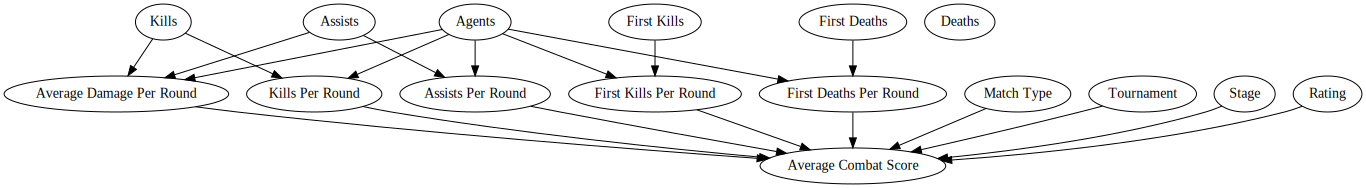

In [11]:
cd

# GLM Set

Now we are going to make a normal GLM based off of our casual diagram but with some different. First as you probably guessed, we aren't going to use the agents column directly. This is because some agents have very little playtime, ie were only use on one game, which would create some crazy outliers. Instead if we group our data based on the in game agent types we would get the same effect. Next some columns are going to get left out, thos ebeing match type, tournament, and stage. The reason they are included in the DAG is because they effect the pressure a player feel, like an elimination game would result in more pressure than a group stage. However, I can't really quantify that in a good way, so I decided to narrow down my data set to help limit the effects of those variables. I chose only games from the largest tournament of the year, Champions 2023. 

Now there are a ton of variables that directly effect average combat score, but I only want to use some. Average Damage Per Round, Kills Per Round, Assists Per Round, First Kills Per Round, and Agent_Type are all the factors I want to use. I am leaving out match type, tournament, and stage as I explained before. Other singular type of data like kills, assists, first kills, first deaths, I want to leave out because the way my dataset is structured is that if a person plays an agent numerous times in a series(a valorant game in the pro scene is either best of 5 or 3 valorant games, called maps) it will aggregate the kills, assists, etc but the ACS will be average. So only per round mesaurements can be used for that. Finally Rating, it is a fan based measurement that is calculated through looking at the amount of times a players name in mentioned in the chat of the livestream, so there is obivous bias to it as more popular players will have a high rating.

Also I want to use agent_type as a hierarchical because from prior knowledge I believe there should be a difference in the predictors based on your agent

In [15]:
#For the sake of clarity, and my sanity, i will be re naming the columns
data = data.rename(columns={
    'Kills Per Round': 'KPR',
    'First Kills Per Round': 'FKPR',
    'Average Damage Per Round': 'ADPR',
    'Assists Per Round': 'APR',
    'Average Combat Score': 'ACS',
})

In [16]:
#here i am just specifying data types, because the warnings piss me off
data['ACS'] = data['ACS'].astype(int)
data['KPR'] = data['KPR'].astype(float)
data['FKPR'] = data['FKPR'].astype(float)
data['ADPR'] = data['ADPR'].astype(float)
data['APR'] = data['APR'].astype(float)
data['Agent_Type'] = data['Agent_Type'].astype(str)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, KPR, FKPR, ADPR, APR]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


<Axes: xlabel='ACS'>

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


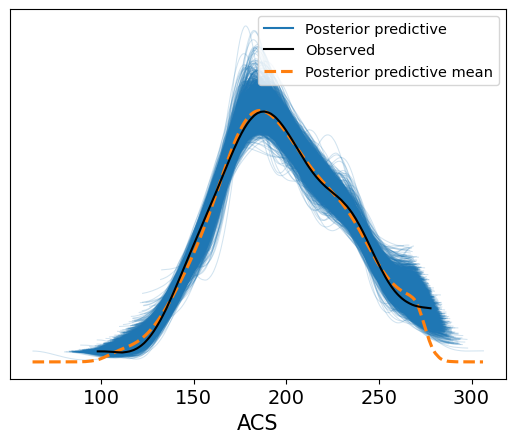

In [17]:
#my first model!
model_glm = bmb.Model("ACS ~ (KPR + FKPR + ADPR + APR) | Agent_Type", data=data, family="t")
idata_glm = model_glm.fit(idata_kwargs={'log_likelihood': True})

model_glm.predict(idata_glm, kind="response")
az.plot_ppc(idata_glm)

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: KPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, FKPR


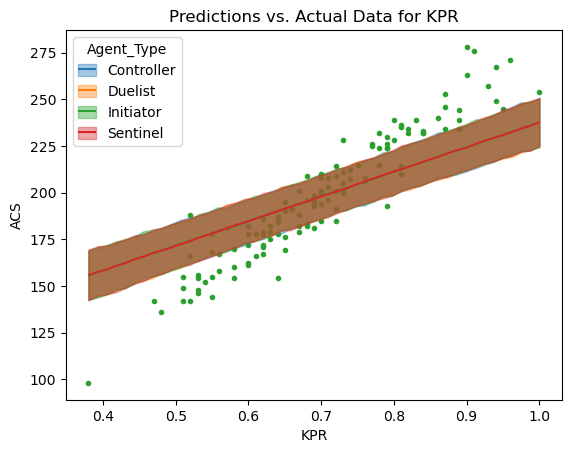

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: FKPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, KPR


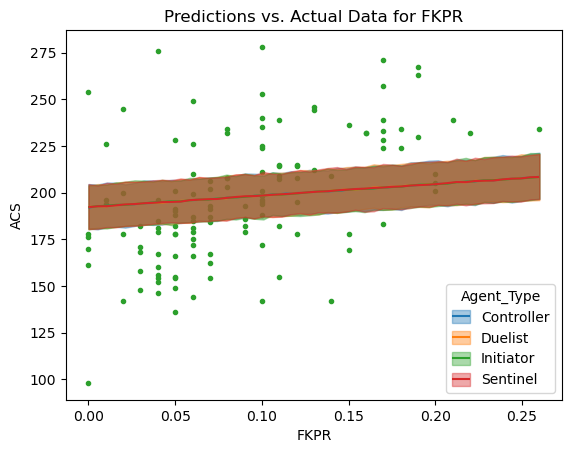

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: ADPR, Agent_Type
Default computed for unspecified variable: APR, FKPR, KPR


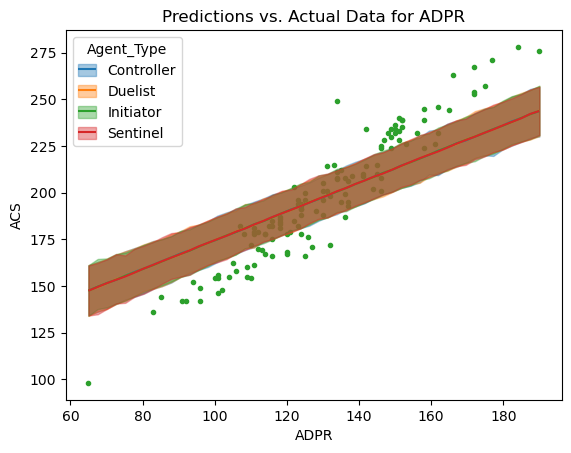

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: APR, Agent_Type
Default computed for unspecified variable: ADPR, FKPR, KPR


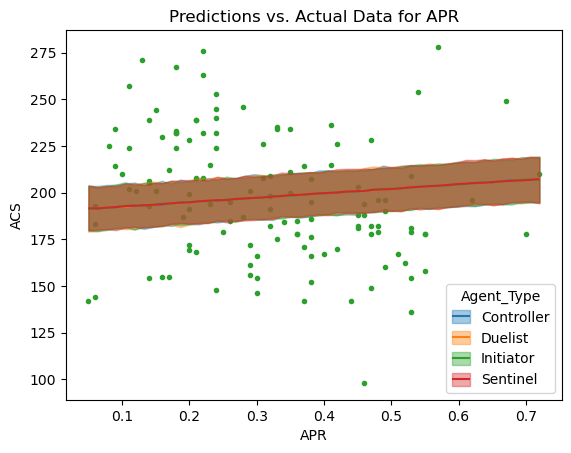

In [25]:
for p in ["KPR", "FKPR", "ADPR", "APR"]:
    plot_predictions_bambi(model_glm, idata_glm, p)

The PPC plot shows that, in general, the model's predictions for average combat score (ACS) match the observed data, but there are some differences at the tails where the model under and over predicts. The KPR plot tells us that while the overall trend for kills per round is captured, the model doesn't fully account for the extra variation seen at higher KPR values. In the FKPR graph, we can see that the model's simple linear assumption misses some details, as its predictions deviate from the actual data in certain ranges. The ADPR graph shows that although the middle range fits well, the extreme low and high values show noticeable differences, suggesting that a more flexible model might be needed. The APR plot, while fairly stable, may have a slight curvature that a strictly linear approach might not capture. Additionally, the graphs show that the relationship between these predictors and ACS isn't all that different between agent types. 

It's interesting that the current results show little difference between agent types because it suggests that the impact of the predictors might be consistent across these agents. This implies that the hierarchical structure may not be adding much variation, even though we expected it might reveal differences. I am still going to maintain the hierarchy to allow for differences if they become apparent.

For the next model, I want to try out a polynomial model. In this model, I'll use a third-degree polynomial for ADPR because the visualization suggested a strong nonlinear pattern at both low and high values of damage, which a cubic term can better capture. For KPR and FKPR, a second-degree polynomial should be enough to allow for moderate curvature in their relationships with ACS without risking overfitting. Similarly, a second-degree polynomial will be applied to APR to account for the subtle curvature.

# Poly

In [26]:
model_poly = bmb.Model(
    "ACS ~ poly(ADPR, degree=3) + poly(KPR, degree=2) + poly(FKPR, degree=2) + poly(APR, degree=2) | Agent_Type",
    data=data,
    family="t"
)
idata_poly = model_poly.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, poly(ADPR, degree=3), poly(KPR, degree=2), poly(FKPR, degree=2), poly(APR, degree=2)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


<Axes: xlabel='ACS'>

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


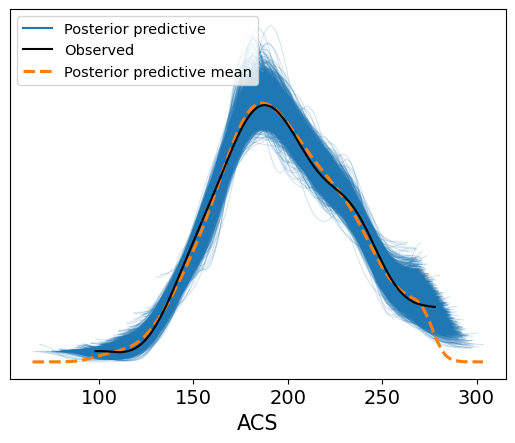

In [28]:
model_poly.predict(idata_poly, kind="response")
az.plot_ppc(idata_poly)

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: KPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, FKPR


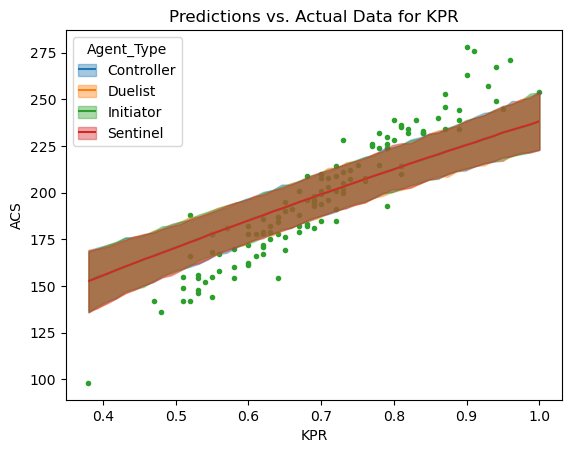

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: FKPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, KPR


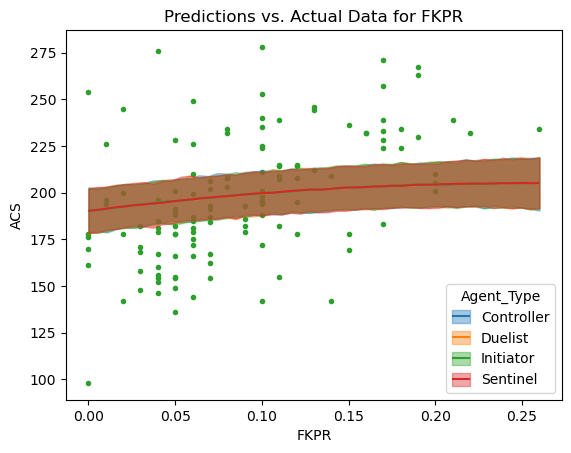

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: ADPR, Agent_Type
Default computed for unspecified variable: APR, FKPR, KPR


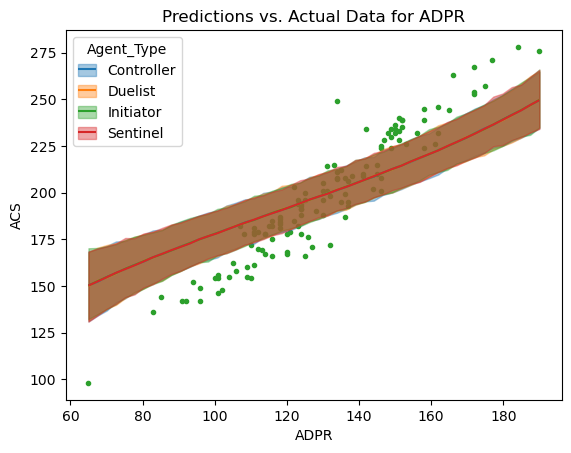

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: APR, Agent_Type
Default computed for unspecified variable: ADPR, FKPR, KPR


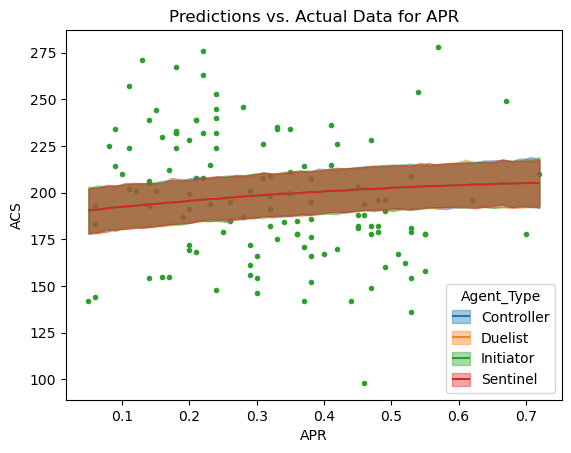

In [30]:
for p in ["KPR", "FKPR", "ADPR", "APR"]:
    plot_predictions_bambi(model_poly, idata_poly, p)

The polynomial model shows a closer fit for most of the data range, as seen in the predicted vs. actual plots for KPR, FKPR, ADPR, and APR. In particular, the curvature in the ADPR plot looks more accurate than in the strictly linear model, especially in the mid-to-high damage ranges where we see a steeper slope. The KPR and FKPR plots help capture some of the previously missed variation, though there is still some scatter at higher kill rates. APR continues to show a relatively steady relationship with ACS, but there is now a slight improvement at the edges where the older model tended to deviate slightly. 

The posterior predictive check reveals that the model does a better job overall of matching the observed distribution of ACS, especially around the peak near 200. However, at the extreme tails—both very low and very high ACS values—there is still some mismatch between predictions and actual observations. This mismatch suggests that the polynomial terms have not fully accounted for all nonlinearities, or that there may be additional factors at play that are not captured in the model. 

Given these results, I’m considering switching to a B-spline model, at least for the ADPR predictor, because B-splines can more flexibly adapt to curvature without imposing a global polynomial shape. On the other hand, if the polynomial model already achieves a strong balance between fit and interpretability—and does not overcomplicate our analysis—sticking to a polynomial approach could be justified. Ultimately, the decision of which model is better will depend on the PPC of BSpline and a elpd loo comparison at the end. 

# BSpline

I chose four knots evenly spaced as a starting point because it balances flexibility and simplicity. With four knots, the spline can adapt to changes in the data without being overly flexible, which helps avoid overfitting, especially when the data points are relatively uniformly spread across the range of ADPR. Evenly spaced knots are also straightforward to implement and interpret, providing a solid baseline. If the data were highly clustered or skewed, placing knots at specific percentiles—might capture the variation better. However, given our current dataset and its spread, evenly spaced knots offer a simple solution to capture the nonlinear relationship in ADPR.

I focused on using a B-spline only for ADPR because the visuals showed that its relationship with ACS was the most nonlinear and complex, especially at the extreme values. In contrast, the other predictors—KPR, FKPR, and APR—seemed to follow a more moderate, less curved relationship with ACS that could be adequately modeled with second-degree polynomial terms. If further analysis shows that any of the other predictors also have hidden nonlinear patterns, we could consider using splines for them as well, but for now, the simpler polynomial approach seems sufficient for those variables.

In [ ]:
num_knots = 4
knots = np.linspace(data['ADPR'].min(), data['ADPR'].max(), num_knots+2)[1:-1]

model_bspline1 = bmb.Model(
    "ACS ~ bs(ADPR, df=None, degree=3, knots=knots) + poly(KPR, 2) + poly(FKPR, 2) + poly(APR, 2) | Agent_Type",
    data=data,
    family="t"
)

idata_bspline1 = model_bspline1.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, bs(ADPR, df=None, degree=3, knots=knots), poly(KPR, 2), poly(FKPR, 2), poly(APR, 2)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.


<Axes: xlabel='ACS'>

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


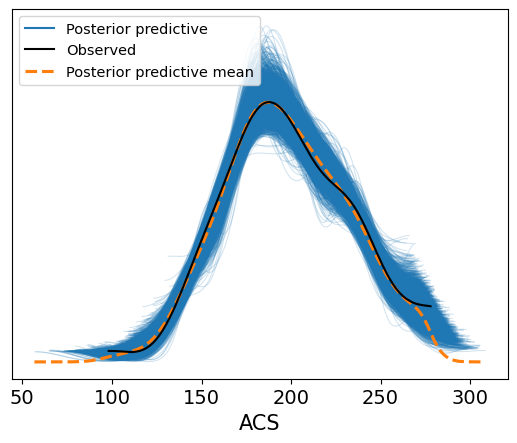

In [32]:
model_bspline1.predict(idata_bspline1, kind="response")
az.plot_ppc(idata_bspline1)

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: KPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, FKPR


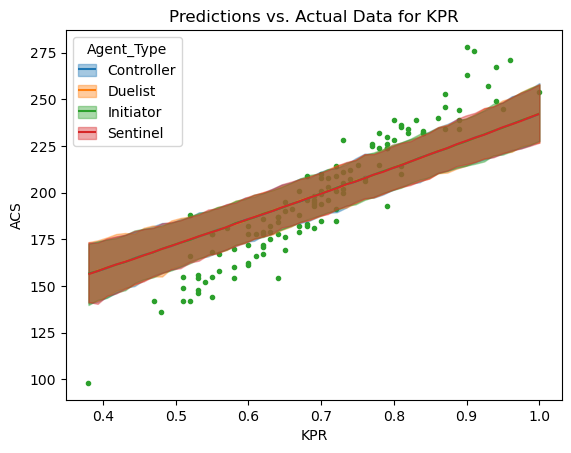

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: FKPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, KPR


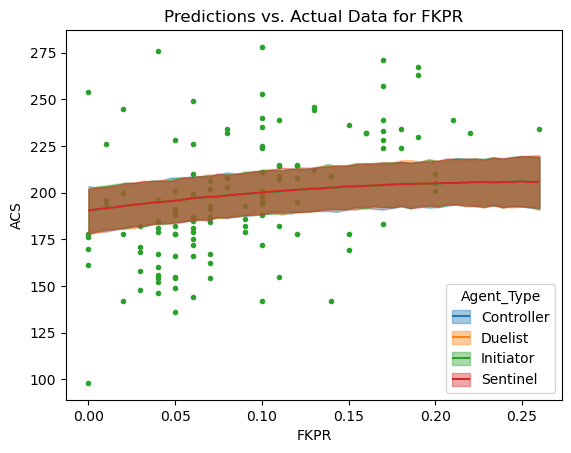

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: ADPR, Agent_Type
Default computed for unspecified variable: APR, FKPR, KPR


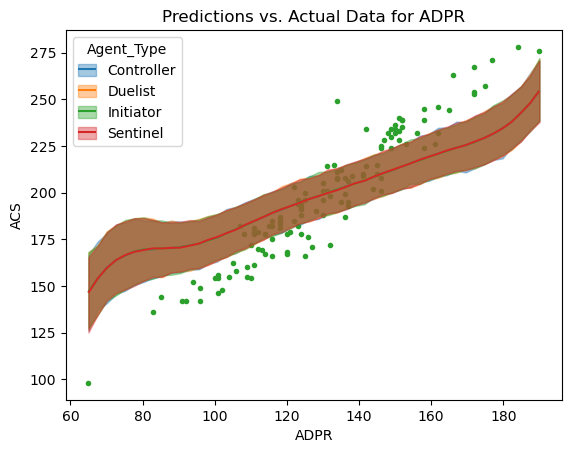

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: APR, Agent_Type
Default computed for unspecified variable: ADPR, FKPR, KPR


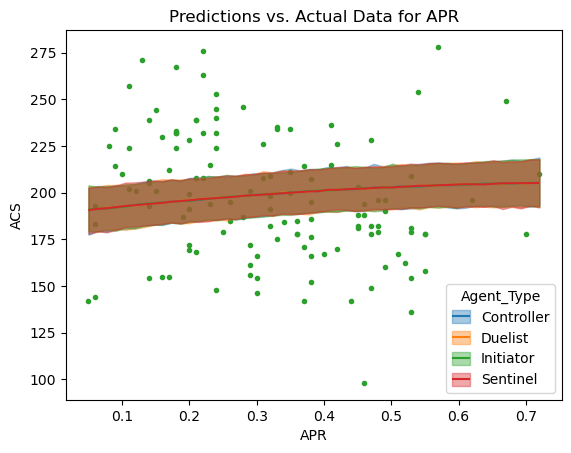

In [33]:
for p in ["KPR", "FKPR", "ADPR", "APR"]:
    plot_predictions_bambi(model_bspline1, idata_bspline1, p)

In this model only ADPR was converted to a spline, while the other predictors remained polynomial. The resulting plots showed that the spline successfully captured the rapid rise in ACS at higher ADPR values and smoothed out mid-range variability more effectively than a purely linear or polynomial term. In the mid-to-low ranges, the predictions aligned closely with the data, although there was still problems at the very lowest ADPR levels. Meanwhile, the polynomial terms for KPR, FKPR, and APR continued to explain most of the data’s variation. However, at the higher KPR values I have noticed minor non-linear trends so I may want to try something out for that. The posterior predictive check indicated an improved fit around the center of the ACS distribution, though some discrepancies persisted at the tails. Overall, introducing a B-spline for ADPR allowed the model to handle curvature better.

Before I move on from bsplines I want to try placing my own knots. In this next model, I used four knots for both ADPR and KPR, placing them at the 20th, 40th, 60th, and 80th percentiles. Again four knots provide enough flexibility to capture potential changes in slope or curvature without adding so many knots that the model risks overfitting. Choosing percentiles rather than evenly spaced knots ensures that the spline can adapt more closely to the actual distribution of the data. I decided to include KPR as a spline because previous visual checks suggested some nonlinear patterns at higher kill rates, and a B-spline can better capture that curvature than a single polynomial shape. 

In [ ]:
adpr_knots = np.percentile(data['ADPR'], [20, 40, 60, 80])
kpr_knots = np.percentile(data['KPR'], [20, 40, 60, 80])

model_bspline2 = bmb.Model(
    "ACS ~ bs(ADPR, df=None, degree=3, knots=adpr_knots) + bs(KPR, df=None, degree=2, knots=kpr_knots) + poly(FKPR, 2) + poly(APR, 2) | Agent_Type",
    data=data,
    family="t"
)

idata_bspline2 = model_bspline2.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, bs(ADPR, df=None, degree=3, knots=adpr_knots), bs(KPR, df=None, degree=2, knots=kpr_knots), poly(FKPR, 2), poly(APR, 2)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.


<Axes: xlabel='ACS'>

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


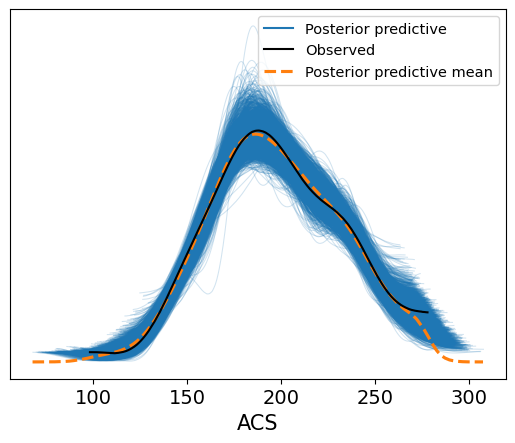

In [35]:
model_bspline2.predict(idata_bspline2, kind="response")
az.plot_ppc(idata_bspline2)

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: KPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, FKPR


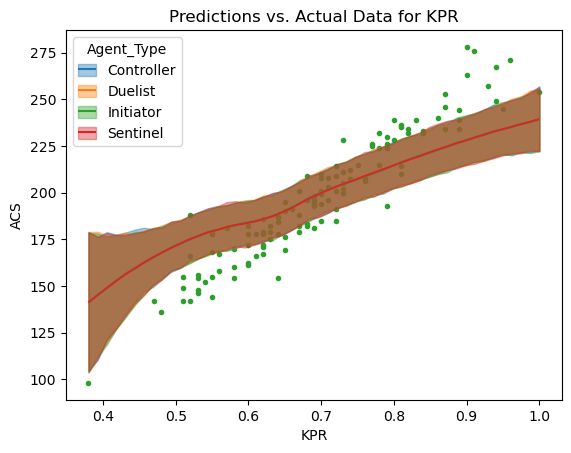

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: FKPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, KPR


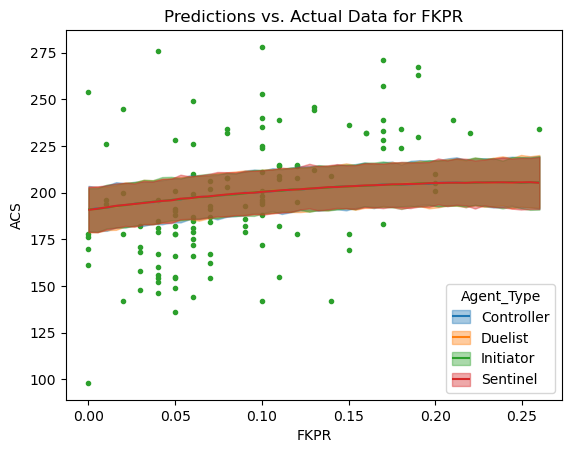

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: ADPR, Agent_Type
Default computed for unspecified variable: APR, FKPR, KPR


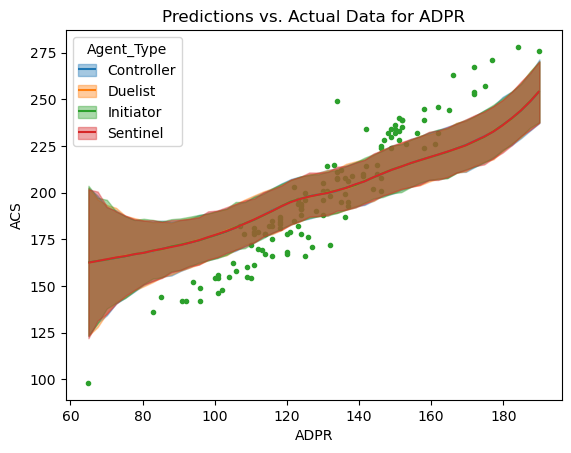

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: APR, Agent_Type
Default computed for unspecified variable: ADPR, FKPR, KPR


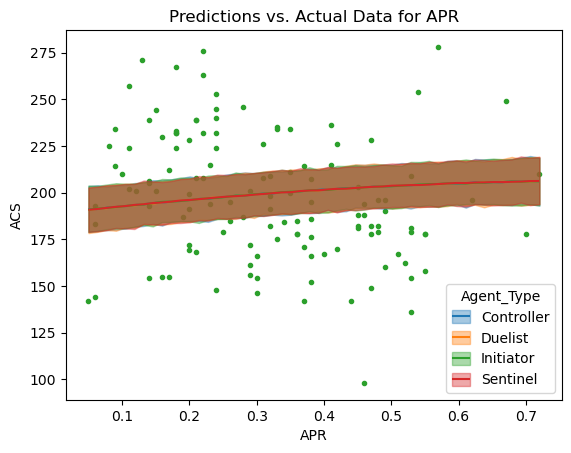

In [36]:
for p in ["KPR", "FKPR", "ADPR", "APR"]:
    plot_predictions_bambi(model_bspline2, idata_bspline2, p)

From the new B-spline model, it appears that both ADPR and KPR now show more curves than in the polynomial-only models. For ADPR, the model adjusts more flexibly in the midrange where most observations cluster, and the predictions capture the sharp increase at higher damage values. Meanwhile, KPR exhibits a slight bend around the 0.6–0.7 region, which the B-spline captures better than a simple polynomial would. FKPR and APR still look relatively stable with their polynomial terms, although we see a small improvement in how the model predicts APR at the lower end. The posterior predictive check is closer with the observed distribution of ACS, especially around the peak, though there is still some scatter at the tails (something that all models are having trouble predicting). Overall, the percentile-based knot placement has yielded smoother fits in areas where we suspected nonlinear behavior.

I think right now my models are good, but before I do the epld_loo I just want to try out the HSGP. 

# HSGP

In this model, I used the HSGP on ADPR. The HSGP component—with 10 basis functions (m=10) and a scaling constant (c=1.5)—allows for a better fit, while the Gamma and InverseGamma priors for σ and ℓ, respectively, ensure that the smoothness of the function is controlled by the data. For KPR, FKPR, and APR, we contunue using a second-degree polynomial expansion. I don't think this model will be my best one, I just wanted to see how it will look. 

In [ ]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5
    return {"alpha": 2, "beta": 2}

adpr_values = data['ADPR'].values.reshape(-1, 1)
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(adpr_values))
}
priors = {
    "hsgp(ADPR, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsgp = bmb.Model(
    "ACS ~ hsgp(ADPR, m=10, c=1.5) + poly(KPR, 2) + poly(FKPR, 2) + poly(APR, 2) | Agent_Type",
    data=data,
    family="t",
    priors=priors
)
idata_hsgp = model_hsgp.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, poly(KPR, 2), poly(FKPR, 2), poly(APR, 2), hsgp(ADPR, m=10, c=1.5)_sigma, hsgp(ADPR, m=10, c=1.5)_ell, hsgp(ADPR, m=10, c=1.5)_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


(80.0, 300.0)

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


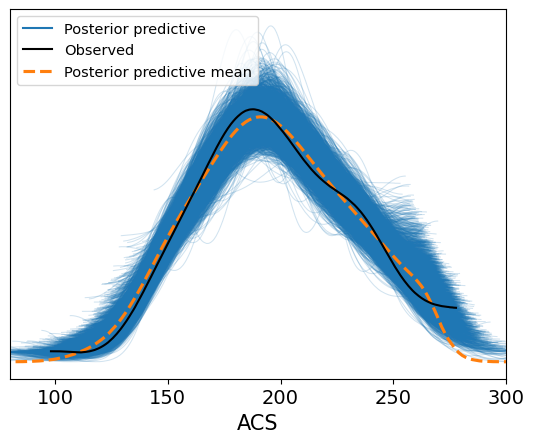

In [40]:
model_hsgp.predict(idata_hsgp, kind="response")
ppc = az.plot_ppc(idata_hsgp)
ppc.set_xlim(80, 300)

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: KPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, FKPR


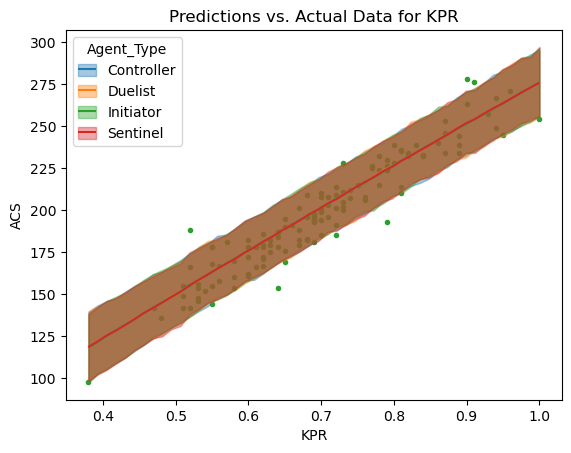

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: FKPR, Agent_Type
Default computed for unspecified variable: ADPR, APR, KPR


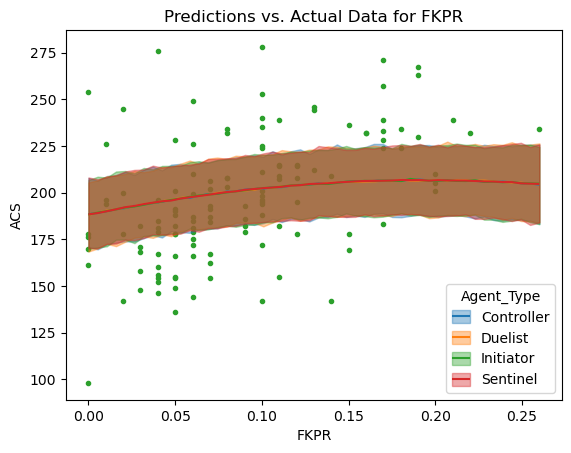

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: ADPR, Agent_Type
Default computed for unspecified variable: APR, FKPR, KPR


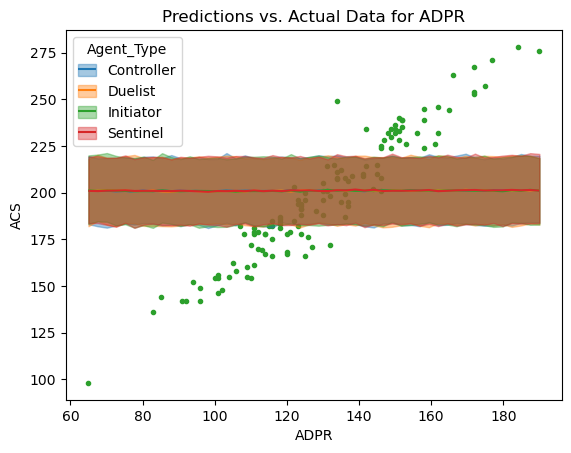

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: APR, Agent_Type
Default computed for unspecified variable: ADPR, FKPR, KPR


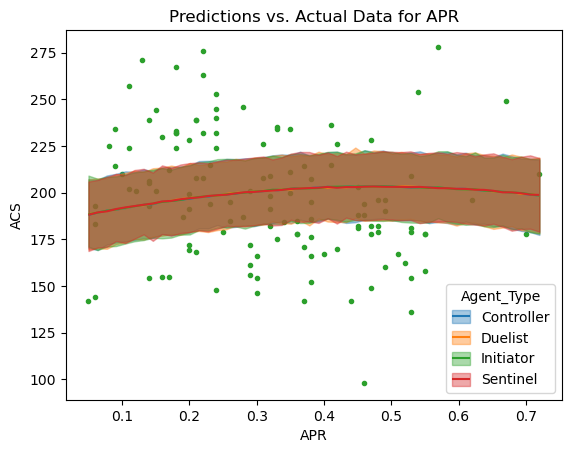

In [39]:
for p in ["KPR", "FKPR", "ADPR", "APR"]:
    plot_predictions_bambi(model_hsgp, idata_hsgp, p)

The new HSGP model captures broad trends but flattens the ADPR relationship more than expected, leading to a large band of uncertainty around the middle range of ADPR. This suggests the model may be over-smoothing and missing the steep rise at higher damage values seen in earlier models. KPR still shows a strong upward slope, and APR has a gentle curve, while FKPR appears only slightly positive. The agent-type differences remain small, so there is little evidence of variation among agent types. The posterior predictive check shows a reasonable fit to the central part of the ACS distribution, though there is still some uncertainty at the lower and higher tails. Overall, this HSGP model seems too cautious about capturing the strong nonlinear effect in ADPR resulting in just a horizontal line. 

# Best Model

Before I look at the elpd_loo I think the best model will be the pure polynomial model as it improves upon the linear model by introducing some curvature while remaining simple compared to splines and gp. Next in line, I think the GLM will be there because the predictors that are the strongest are KPR and ADPR which it does a decent job of modelling. Next, second B-spline model, which uses custom knots for both ADPR and KPR. This setup is likely to capture  curvature more accurately by placing knots at key percentiles where the data changes most, resulting in a more flexible fit for these predictors. The first B-spline model—which applies a spline only to ADPR while keeping the other predictors as polynomials—should perform nearly as well, as it improves the fit for the most nonlinear relationship without complicating the entire model. The HSGP model, although promising in theory, seems to over-smooth the ADPR relationship, flattening its steep rise and leading to high uncertainty, which may reduce its performance. 






c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

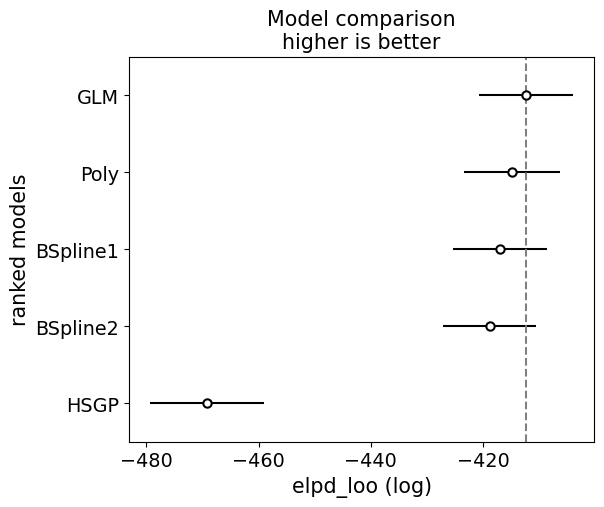

In [ ]:
elpd_loo = az.compare({'GLM' : idata_glm, 'Poly' : idata_poly, 'BSpline1' : idata_bspline1, 'BSpline2' : idata_bspline2, 'HSGP' : idata_hsgp})
az.plot_compare(elpd_loo)

According to the ELPD LOO results, the simple GLM ended up performing the best overall, followed by the pure polynomial model in second place. The two B-spline models came in third and fourth, with the first B-spline (only on ADPR) slightly outperforming the second B-spline (on both ADPR and KPR). The HSGP model ranked last, which aligns with our earlier observation that it tended to over-smooth ADPR. These rankings suggest that adding more complex terms did not translate into better accuracy. It may be that the data’s strongest patterns are already well-captured by a simpler structure, or that the penalty for extra parameters outweighed the improvements from splines or the GP. Now to be fair the differences between the GLM, Poly, & BSplines aren't that big. The error bars are barely different for the top 4 models meaning there really isn't that big of a difference between them. So to improve the model I think we would need other factors that we don't have that would effect the model. 

Specifically I can think of 2 reasons, multikills and support vs damage assists. Multikills are when you get multiple kills in a row which could increase your ACS. The other reason is assists being either support or damage based. A damage based assist is where you deal damage to the enemy and die without killing them, but your teammate kills them later on. Since you weakened the enemy you would get an assist, these types are more common, but they probably aren't included in ACS as damage is probably its own calculation. Since damage based assists are already taken care of through damage, support based assists will be isolated in the calculation. However, our dataset doesn't isolate them so it could result in the variation we see in our APR graph. 

# Conclusions

Overall, this project showed that a relatively simple model could capture most of the key relationships in the data, despite my initial belief that more complex approaches would be necessary. In analyzing the Valorant Champions 2023 dataset, I expected that agent type would have a strong impact on performance; however, the hierarchical models revealed only minor differences among the groups. This suggests that, in this particular tournament setting, ACS is driven more by individual metrics—especially kills and damage—than by the agent category itself. A key takeaway is that KPR and ADPR consistently emerged as the strongest predictors of ACS, reinforcing the intuitive notion that getting kills and dealing damage are crucial to in-game success. FKPR and APR, while still contributing to the model, had more subtle effects, indicating that first kills and assists per round are less influential than the core metrics of kills and damage. As I mentioned before the difference between damage and support assists could be are reason for this. 

I experimented with several modeling approaches, including basic GLMs, a pure polynomial model, two variants of B-spline models (one applying a spline only to ADPR and another using custom knots for both ADPR and KPR), and an HSGP. Surprisingly, the GLM model performed equal too or better than the more flexible polynomial, spline, and GP models, as evidenced by the elpd loo. The HSGP, although theoretically appealing, tended to over-smooth the ADPR relationship, resulting in it not capturing the rise in performance. This analysis ultimately reinforced that the simplest model capable of capturing the main drivers—KPR, ADPR, along with the supporting roles of FKPR and APR—can perform on par or better than the more elaborate models, and that expectations, such as large differences between agent types, are not always confirmed by the evidence.